# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


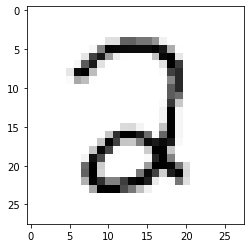

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2502
Training Accuracy: 0.5522, Testing Accuracy: 0.5615



Epoch 10, Loss 0.1961
Training Accuracy: 0.8538, Testing Accuracy: 0.8574



Epoch 20, Loss 0.1036
Training Accuracy: 0.8976, Testing Accuracy: 0.9078



Epoch 30, Loss 0.0649
Training Accuracy: 0.9306, Testing Accuracy: 0.9355



Epoch 40, Loss 0.0494
Training Accuracy: 0.9451, Testing Accuracy: 0.9536



Epoch 50, Loss 0.0418
Training Accuracy: 0.9512, Testing Accuracy: 0.9612



Epoch 60, Loss 0.0373
Training Accuracy: 0.9567, Testing Accuracy: 0.9662



Epoch 70, Loss 0.0343
Training Accuracy: 0.9604, Testing Accuracy: 0.9677



Epoch 80, Loss 0.0322
Training Accuracy: 0.9627, Testing Accuracy: 0.9703



Epoch 90, Loss 0.0305
Training Accuracy: 0.9651, Testing Accuracy: 0.9703



Epoch 100, Loss 0.0292
Training Accuracy: 0.9664, Testing Accuracy: 0.9698



Epoch 110, Loss 0.0281
Training Accuracy: 0.9670, Testing Accuracy: 0.9708



Epoch 120, Loss 0.0271
Training Accuracy: 0.9675, Testing Accuracy: 0.9718



Epoch 130, Loss 0.0262
Training Accuracy: 0.9685, Testing Accuracy: 0.9723



Epoch 140, Loss 0.0255
Training Accuracy: 0.9692, Testing Accuracy: 0.9728



Epoch 150, Loss 0.0248
Training Accuracy: 0.9709, Testing Accuracy: 0.9733



Epoch 160, Loss 0.0242
Training Accuracy: 0.9713, Testing Accuracy: 0.9733



Epoch 170, Loss 0.0236
Training Accuracy: 0.9722, Testing Accuracy: 0.9733



Epoch 180, Loss 0.0231
Training Accuracy: 0.9729, Testing Accuracy: 0.9738



Epoch 190, Loss 0.0226
Training Accuracy: 0.9742, Testing Accuracy: 0.9748



Epoch 200, Loss 0.0221
Training Accuracy: 0.9750, Testing Accuracy: 0.9753



Epoch 210, Loss 0.0217
Training Accuracy: 0.9756, Testing Accuracy: 0.9758



Epoch 220, Loss 0.0212
Training Accuracy: 0.9760, Testing Accuracy: 0.9758



Epoch 230, Loss 0.0208
Training Accuracy: 0.9765, Testing Accuracy: 0.9758



Epoch 240, Loss 0.0205
Training Accuracy: 0.9768, Testing Accuracy: 0.9763



0.029272536109284614

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2551
Training Accuracy: 0.6494, Testing Accuracy: 0.6381



Epoch 10, Loss 0.1051
Training Accuracy: 0.9018, Testing Accuracy: 0.9168



Epoch 20, Loss 0.0809
Training Accuracy: 0.9215, Testing Accuracy: 0.9365



Epoch 30, Loss 0.0697
Training Accuracy: 0.9325, Testing Accuracy: 0.9476



Epoch 40, Loss 0.0629
Training Accuracy: 0.9386, Testing Accuracy: 0.9506



Epoch 50, Loss 0.0582
Training Accuracy: 0.9432, Testing Accuracy: 0.9526



Epoch 60, Loss 0.0548
Training Accuracy: 0.9462, Testing Accuracy: 0.9551



Epoch 70, Loss 0.0521
Training Accuracy: 0.9480, Testing Accuracy: 0.9567



Epoch 80, Loss 0.05
Training Accuracy: 0.9508, Testing Accuracy: 0.9597



Epoch 90, Loss 0.0482
Training Accuracy: 0.9519, Testing Accuracy: 0.9597



Epoch 100, Loss 0.0468
Training Accuracy: 0.9528, Testing Accuracy: 0.9622



Epoch 110, Loss 0.0455
Training Accuracy: 0.9538, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0444
Training Accuracy: 0.9548, Testing Accuracy: 0.9632



Epoch 130, Loss 0.0434
Training Accuracy: 0.9558, Testing Accuracy: 0.9632



Epoch 140, Loss 0.0426
Training Accuracy: 0.9563, Testing Accuracy: 0.9652



Epoch 150, Loss 0.0418
Training Accuracy: 0.9573, Testing Accuracy: 0.9652



Epoch 160, Loss 0.0411
Training Accuracy: 0.9579, Testing Accuracy: 0.9642



Epoch 170, Loss 0.0405
Training Accuracy: 0.9585, Testing Accuracy: 0.9642



Epoch 180, Loss 0.0399
Training Accuracy: 0.9589, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0393
Training Accuracy: 0.9593, Testing Accuracy: 0.9657



Epoch 200, Loss 0.0388
Training Accuracy: 0.9597, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0384
Training Accuracy: 0.9602, Testing Accuracy: 0.9662



Epoch 220, Loss 0.038
Training Accuracy: 0.9604, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0376
Training Accuracy: 0.9602, Testing Accuracy: 0.9677



Epoch 240, Loss 0.0372
Training Accuracy: 0.9604, Testing Accuracy: 0.9677



0.0204683434759674

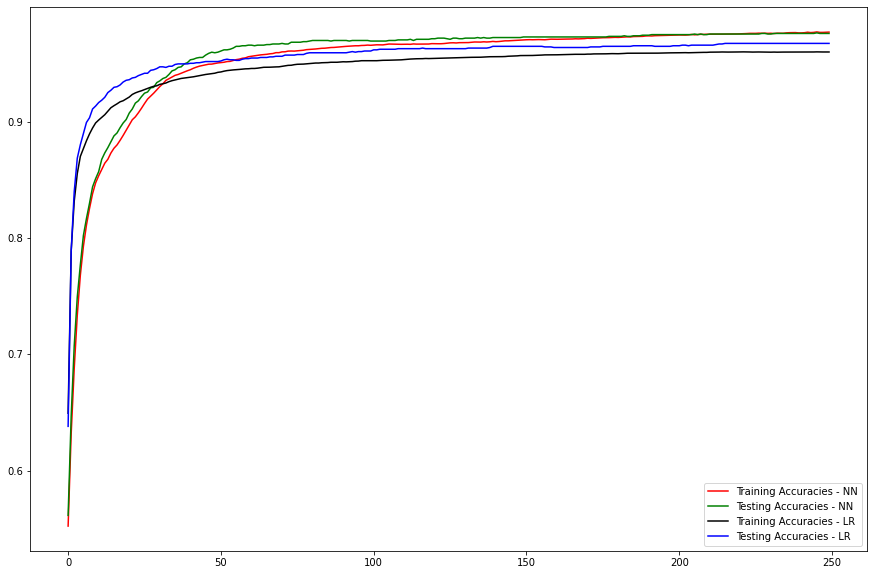

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

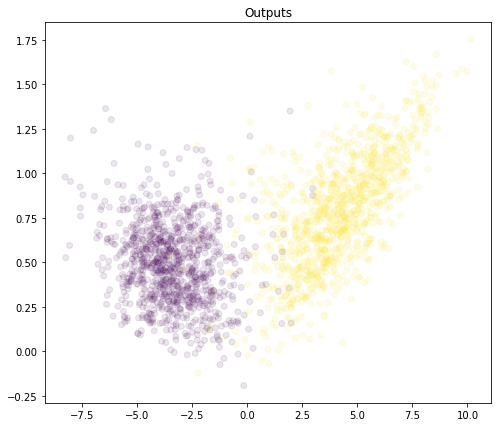

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

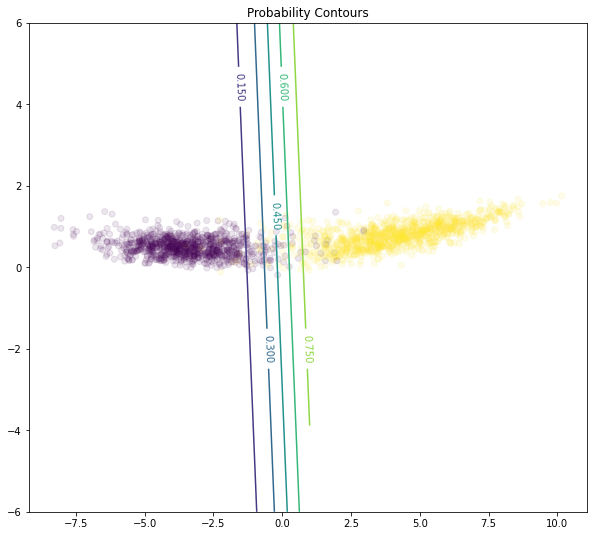

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );